Poner el diagrama y el esquema general del código

In [40]:
import os
import cv2
import time
import torch
import scipy.signal
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output
from odak.learn.tools        import save_image
from odak.learn.tools.matrix import zero_pad, crop_center
from odak.learn.wave         import calculate_amplitude, calculate_phase, propagate_beam, generate_complex_field, linear_grating
from odak.learn.wave.util    import wavenumber

# Funciones

This function simulates the propagation of light through an f-f system: a portion of free space of thickness f, a lens of focal length f>0, and a second portion of free space of thickness f.

In [42]:
def function_lens(field1, pixel, f, wavelength):

    if f < 0:
        field2 = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(field1)))
    else:
        field2 = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(field1)))

    NX, NY = field1.shape
    psX = abs(f * wavelength / (NX * pixel))
    psY = abs(f * wavelength / (NY * pixel))

    return field2, psX, psY

# Function_propagate

Esta función simula la propagación paraxial de un campo complejo 2D
Entradas:

- field1 = campo complejo (amplitud .* exp(i*phase)) en z=0,
- psx = tamaño de píxel a lo largo del eje x
- psy = tamaño de píxel a lo largo del eje y
- longitud de onda
- z = distancia de propagación deseada

Salidas:
- field2 = el campo complejo en la distancia z

In [43]:
def function_propagate(field1, wavelength, z, psx, psy):

    M, N = field1.shape
    if M % 2 == 1:
        UY = np.arange(1, M + 1) - np.mean(np.arange(1, M + 1)) - 1
    else:
        UY = np.arange(1, M + 1) - np.mean(np.arange(1, M + 1)) - 0.5

    if N % 2 == 1:
        UX = np.arange(1, N + 1) - np.mean(np.arange(1, N + 1)) - 1
    else:
        UX = np.arange(1, N + 1) - np.mean(np.arange(1, N + 1)) - 0.5

    x, y = np.meshgrid(UX, UY)
    
    kx = x / (psx * N)
    ky = y / (psy * M)

    H = np.exp(-1j * np.pi * wavelength * z * (kx**2 + ky**2))
    H = np.fft.fftshift(H)
    objFT = np.fft.fft2(field1)
    field2 = np.fft.ifft2(objFT * H)
    
    return field2

# function_GS_Z

Implementación del algoritmo Gerchberg-Saxton para optimizar patrones de modulación de onda coherente

Entradas: 
- target_amplitude = distribución de intensidad 3D objetivo
- N = número de iteraciones
- z = ubicación del objetivo a lo largo del plano z

Salidas:
- DMDPattern = un patrón DMD optimizado

    laser_amplitude = np.exp(-((XX ** 2 + YY ** 2) / Setup.laserradius ** 2))
    FieldB = laser_amplitude * np.exp(1j * 2 * np.pi * np.random.rand(Setup.DMDX, Setup.DMDY))
    FieldA, psx, psy = function_lens(FieldB, Setup.ps, Setup.ps, Setup.f, Setup.lambda)
    URX = psx * (np.arange(1, Setup.DMDX + 1) - np.mean(np.arange(1, Setup.DMDX + 1)))
    URY = psy * (np.arange(1, Setup.DMDY + 1) - np.mean(np.arange(1, Setup.DMDY + 1)))
    RXX, RYY = np.meshgrid(URX, URY)

In [44]:
def function_GS_Z(resolution, N, z, target):
    global FieldA, FieldB
    # Inicializar con amplitud deseada y fase aleatoria
    #FieldZ = target * np.exp(1j * 2 * np.pi * np.random.rand(resolution[0], resolution[1]))
    mask = np.double(np.sqrt(XX ** 2 + YY ** 2) < 0.00001)
    #FieldB = laser_amplitude * np.exp(1j * 2 * np.pi * np.random.rand(resolution[0], resolution[1]))
    # Iteración
    for i in range(N):
        # Propagar desde z=0 hasta plano DMD
        FieldA, _, _ = function_lens(FieldB, pixel, focal_distance, wavelength)
        
        # Umbral en el valor medio para llenar aproximadamente la mitad del DMD
        Amplitude = np.abs(FieldA)
        DMDPattern = np.double(Amplitude > (np.median(Amplitude)))
        FieldA = laser_amplitude * DMDPattern

        # Regresar al plano de imagen
        FieldB, psx, psy = function_lens(FieldA, pixel, - focal_distance, wavelength)

        # Normalizar FieldB
        FieldB = FieldB / np.sqrt(np.sum(np.abs(FieldB) ** 2))
        EnergyinSignal = np.sum(np.abs((1 - mask) * FieldB) ** 2)

        # Propagar desde z=0 a z y propagar solo la señal
        fieldZ = function_propagate((1 - mask) * FieldB, wavelength, z, psy, psx)

        # Actualizar amplitud
        fieldZ = np.sqrt(EnergyinSignal) * target * np.exp(1j * np.angle(fieldZ))

        # Propagar desde z a z=0 y propagar solo la señal
        fieldNB = function_propagate(fieldZ, wavelength, - z, psy, psx)

        # Agregar el término DC nuevamente en z=0
        FieldB = (mask) * FieldB + (1 - mask) * fieldNB

    return DMDPattern

# Function Rendering

Genera imágenes a una distancia específica (z) a partir de patrones almacenados en un dispositivo de modulación digital de microespejos (DMD)

Inputs:
- z = an array of size LZ corresponding to the propagation distance of the image depth planes
- DMDPatterns = a set of p DMD patterns of size LX, LY, p

Outputs:
- VolumeImage = A stack of intensity data corresponding to individually propagated coherent waves, of size
- LX, LY, LZ, p

In [45]:
def function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns):
    LX, LY, LP = DMDPatterns.shape

    VolumeImage = np.zeros((resolution[0], resolution[1], LP))
    
    for k in range(LP):
        FieldA = laser_amplitude * DMDPatterns[:, :, k]

        # go to image plane
        FieldB, psx, psy = function_lens(FieldA, pixel, - focal_distance, wavelength)

        FieldB = FieldB / np.sqrt(np.sum(np.abs(FieldB)**2))

        fieldZ = function_propagate((1 - mask) * FieldB, wavelength, z, psy, psx)
        fieldZ = fieldZ / np.sqrt(np.sum(np.abs(fieldZ)**2))
        
        VolumeImage[:, :, k] = np.abs(fieldZ**2)

    return VolumeImage

# Function_accuracy
accuracy is a measure of mismatch between A and B.

In [46]:
def function_accuracy(A, B):

    prod = A * B
    accuracy = np.sum(prod) / np.sqrt(np.sum(A**2) * np.sum(B**2))
    return accuracy

# Function_GS_Z3D_inc

This is a core step of the DCGH - Gerchberg–Saxton algorithm to optimize several coherent wave modulation patterns at once.

Inputs:
- target_amplitude = target 3D intensity distribution
- z = location of target along the z plane
- DMDPatternref = an initial estimation of the DMDPattern to be optimized

Outputs:
- DMDPattern = the updated DMD pattern

In [47]:
def function_GS_Z3D_inc(focal_distance, wavelength, DMDPatterns, z, target):
    mask = np.sqrt(XX**2 + YY**2) < 0.0001

    FieldA = laser_amplitude * DMDPatterns

    # go back to image plane
    FieldB, psx, psy = function_lens(FieldA, pixel, - focal_distance, wavelength )

    FieldB = FieldB / np.sqrt(np.sum(np.abs(FieldB)**2))
    EnergyinSignal = np.sum(np.abs((1 - mask) * FieldB)**2)

    fieldNB = FieldB - FieldB

    # Go from zero to z propagate the signal only
    fieldZ = function_propagate((1 - mask) * FieldB, wavelength, z, psy, psx)

    # Update the amplitude
    fieldZ = np.sqrt(EnergyinSignal) * target[:, :] * np.exp(1j * np.angle(fieldZ))

    # Go from z to zero propagate the signal only
    fieldNB = fieldNB + function_propagate(fieldZ, wavelength, -z, psy, psx)

    fieldNB = fieldNB / np.sqrt(np.sum(np.abs(fieldNB)**2))

    # Add the DC term back at z=0
    FieldB = (mask) * FieldB + (1 - mask) * fieldNB
    # start in z=0 Go to DMD plane
    FieldA, _, _ = function_lens(FieldB, psx, focal_distance, wavelength)

    # Threshold at median value to fill about half the DMD
    Amplitude = np.abs(FieldA)
    DMDPattern = (Amplitude > (np.median(Amplitude)))

    return DMDPattern

# Variables y Parámetros

In [ ]:
#______________________________________________PARÁMETROS DE ENTRENAMIENTO
iteration_number = 1000
learning_rate = 5e-3

#iteraciones en la optimización
N = 10

#número de patrones coherentes promediados en el tiempo
P = 4

#______________________________________________DIRECCIÓN DE GUARDADO
path_images_test = "images_test"
save_path = f"calibrated_parameters"

#______________________________________________VARIABLES DE ENTRADA DEL SISTEMA FÍSICO
wavelength = 635e-9
focal_distance = 0.22
radio_lente = 2.5e-3
z = 0.05

#Radius of the gaussian laser spot on DMD
laserradius = 200e-4

#Número de onda
k0 = wavenumber(wavelength) 

#Polinomio para el índice de refracción
Lb = wavelength * 1e6
IdLens = 1.5375 + 0.00829045 * Lb**(-2) - 0.000211046 * Lb**(-4)

#______________________________________________VARIABLES DEL DISPOSITIVO
pixel = 13.3e-6
resolution = [512, 512]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Caracterización del Láser

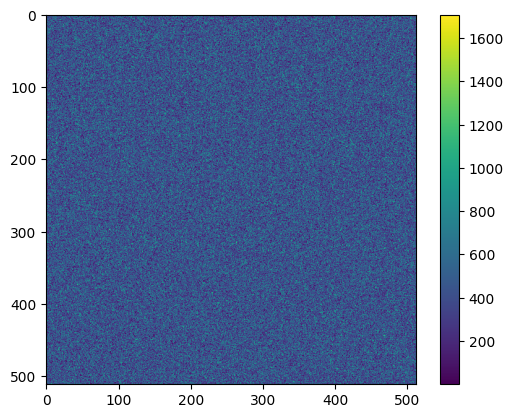

In [48]:
UX = pixel*np.arange(1,resolution[0]+1); UY = pixel*np.arange(1,resolution[1]+1)
UX = UX - np.mean(UX); UY = UY - np.mean(UY)
XX, YY = np.meshgrid(UX, UY)

#Creación de la máscara
mask = np.sqrt(XX**2 + YY**2) < 0.0001

laser_amplitude = np.exp(-((XX**2 + YY**2) / laserradius**2))
FieldB = laser_amplitude * np.exp(1j * 2 * np.pi * np.random.rand(resolution[0], resolution[1]))
FieldA, psx, psy = function_lens(FieldB,pixel,focal_distance,wavelength)
plt.imshow(abs(FieldA))
#plt.imshow(abs(laser_amplitude))
plt.colorbar()
plt.show()


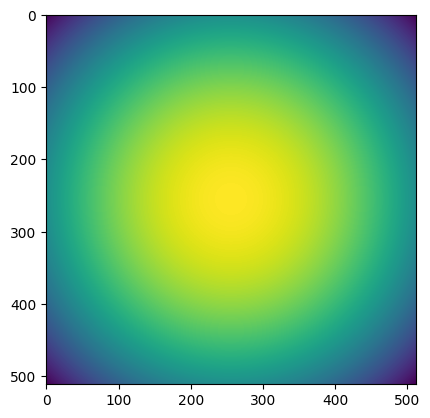

In [49]:
plt.imshow(abs(FieldB))
plt.show()

In [50]:
URX = psx*np.arange(1,resolution[0]+1); URY = psy*np.arange(1,resolution[1]+1)
URX = URX-np.mean(URX); URY = URY-np.mean(URY)

#URX, URY is the real space axis limit, note the non square pixel size
RXX, RYY = np.meshgrid(URX, URY)

Carga de las imágenes

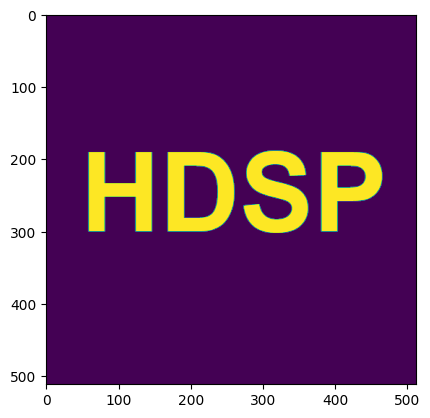

In [51]:
from PIL import Image

target_intensity = np.array(Image.open('Target_Images/HDSP.png'))
target_amplitude = np.sqrt(np.mean(target_intensity, axis=2)).astype(float)
target_amplitude /= np.max(target_amplitude)
#target = np.concatenate((target_amplitude, np.rot90(np.rot90(target_amplitude))), axis=1)

#aquí tengo que hacer algo por si la imagen no es de pares
equis = (resolution[0] - target_amplitude.shape[0]) // 2
yes = (resolution[1] + 1 - target_amplitude.shape[1]) // 2

target_padded = np.pad(target_amplitude, ((equis, equis),(yes, yes)),
                                           mode='constant', constant_values=0)

target = np.zeros(target_padded[:, :].shape)
target[:, :] = np.squeeze(target_padded[:, :]) / np.sqrt(np.sum(np.abs(target_padded[:, :])**2))
plt.imshow(target)
plt.show()

In [52]:
DMDPatterns = np.zeros((resolution[0], resolution[1], P)) # Inicializa DMDPatterns

for k in range(P):
    DMDPatterns[:,:,k] = function_GS_Z(resolution, N, z, target)

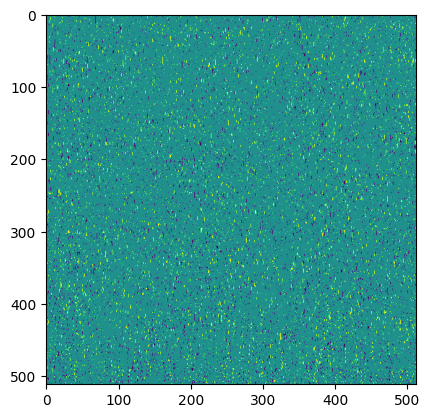

In [53]:
resta = DMDPatterns[:,:,0] - DMDPatterns[:,:,1]
plt.imshow(resta)
plt.show()

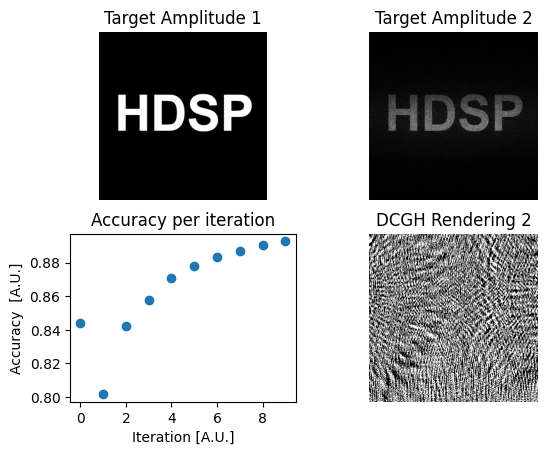

In [54]:
VolumeImages = function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns)
ta = np.zeros(N)
contador = np.zeros(N)

for i in range(N):
    VolumeImageAV = np.mean(VolumeImages, axis=2)

    # Display
    f = plt.figure(1)
    plt.subplot(2, 2, 1)
    plt.imshow(target[:, :], cmap='gray')
    plt.axis('off')
    plt.title('Target Amplitude 1')

    plt.subplot(2, 2, 2)
    plt.imshow(VolumeImageAV[:, :], cmap='gray')
    plt.axis('off')
    plt.title('Target Amplitude 2')

    ta[i] = function_accuracy(VolumeImageAV, target**2)
    contador[i] = i

    plt.subplot(2, 2, 3)
    plt.scatter(contador, ta)
    plt.title('Accuracy per iteration')
    plt.ylabel('Accuracy  [A.U.]')
    plt.xlabel('Iteration [A.U.]')

    plt.subplot(2, 2, 4)
    plt.imshow(DMDPatterns[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.title('DCGH Rendering 2')

    # New target amplitude computation
    for k in range(P):
        newa = target - target
        
        baseintensity = target[:, :]**2
            
        for q in range(P):
            if q != k:
                baseintensity -= VolumeImages[:, :, q] / P
                
        newa[:, : ] = np.sqrt(np.maximum(baseintensity, 0))

        #Use target amplitude to update DMD patterns
        DMDPatterns[:, :, k] = function_GS_Z3D_inc(focal_distance, wavelength, DMDPatterns[:, :, k], z, newa)

    # Render images from DMD patterns
    VolumeImages = function_Rendering(pixel, resolution, focal_distance, wavelength, z, DMDPatterns)

    plt.draw()
    plt.show()
    clear_output(wait=True)


<function matplotlib.pyplot.show(close=None, block=None)>

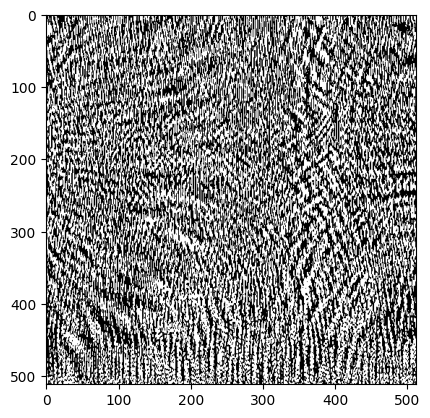

In [55]:
#Revisar la variables del sistema que sí están entre 0 ó 1s
plt.imshow(DMDPatterns[:,:,1],cmap='gray')
plt.show

In [56]:
suma_total = np.sum(DMDPatterns, axis=2)
suma_total

array([[1., 3., 0., ..., 3., 3., 2.],
       [0., 3., 0., ..., 3., 3., 1.],
       [0., 2., 0., ..., 3., 3., 2.],
       ...,
       [4., 3., 4., ..., 1., 3., 2.],
       [4., 3., 3., ..., 2., 2., 1.],
       [3., 4., 0., ..., 4., 3., 1.]])

In [57]:
media_valores = np.mean(VolumeImages, axis = 2)
errores_cuadrados = np.zeros((resolution[0], resolution[1], P))

for i in range(P):
    errores_cuadrados[:,:,i] = (VolumeImages[:,:,i] - media_valores[:,:])**2

suma_errores_cuadrados = np.sum(errores_cuadrados, axis=2)
rmse = np.sqrt(suma_errores_cuadrados / P)

<function matplotlib.pyplot.show(close=None, block=None)>

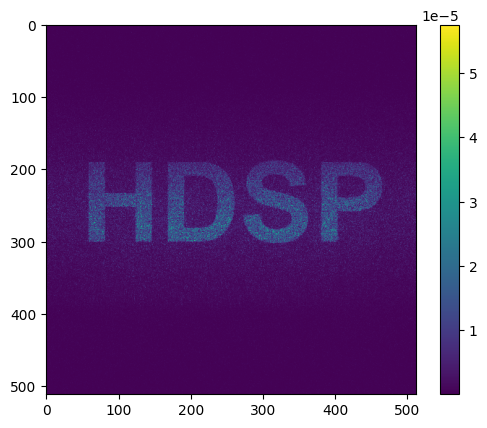

In [58]:
plt.imshow(rmse)
plt.colorbar()
plt.show